<a name="top" id="top"></a>

<div align="center">
    <h1>Quantum Annealing via D-Wave</h1>
    <a href="https://github.com/bernalde">David E. Bernal Neira</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <i>Universities Space Research Association</i>
    <br>
    <i>NASA QuAIL</i>
    <br>
    <br>
    <a href="https://github.com/pedromxavier">Pedro Maciel Xavier</a>
    <br>
    <i>Computer Science &amp; Systems Engineering Program, Federal University of Rio de Janeiro</i>
    <br>
    <i>PSR Energy Consulting &amp; Analytics</i>
    <br>
    <br>
    <a href="https://colab.research.google.com/github/SECQUOIA/QUBONotebooks/blob/main/notebooks/2-QUBO.ipynb" target="_parent">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="#installation">
        <img src="https://img.shields.io/badge/⚙️-Installation_Instructions-blue" alt="Installation Instructions"/>
    </a>
    <a href="https://bernalde.github.io/">
        <img src="https://img.shields.io/badge/⚗️-Bernal_Lab-blue" alt="Bernal Lab"/>
    </a>
</div>

### Activate Environment

In [1]:
import Pkg; Pkg.activate(@__DIR__) # Here we go!

  Activating project at `~/gits/QUBO-notebooks/notebooks`


## About this Notebook

This notebook will give the first interaction with D-Wave's Quantum Annealer.
It will use the QUBO modeling problem introduced earlier and will define it using **[JuMP](https://jump.dev)**, and then solve them using neal's implementation of simulated annealing classicaly and D-Wave system package to use Quantum Annealing.
We will also leverage the use of **[Graphs.jl](https://github.com/JuliaGraphs/Graphs.jl)** for network models/graphs.

## Problem statement

We define a QUBO as the following optimization problem:

$$
\min_{x \in \{0,1 \}^n} \sum_{(ij) \in E(G)} Q_{ij}x_i x_j + \sum_{i \in V(G)}Q_{ii}x_i + \beta = \min_{x \in \{0,1 \}^n}  \mathbf{x}' \mathbf{Q} \mathbf{x} + \beta
$$

where we optimize over binary variables $x \in \{ 0,1 \}^n$, on a constrained graph $G(V,E)$ defined by a weighted adjacency matrix $\mathbf{Q}$.
We also include an arbitrary offset  $\beta$.

### Example

Suppose we want to solve the following problem via QUBO

$$
\begin{array}{rl}
\displaystyle%
\min_{\mathbf{x}} & 2x_0+4x_1+4x_2+4x_3+4x_4+4x_5+5x_6+4x_7+5x_8+6x_9+5x_{10} \\
\textrm{s.t.}     & \begin{bmatrix}
1 & 0 & 0 & 1 & 1 & 1 & 0 & 1 & 1 & 1 & 1\\
0 & 1 & 0 & 1 & 0 & 1 & 1 & 0 & 1 & 1 & 1\\
0 & 0 & 1 & 0 & 1 & 0 & 1 & 1 & 1 & 1 & 1
\end{bmatrix}\mathbf{x}=
\begin{bmatrix}
1\\
1\\
1
\end{bmatrix} \\
~ & \mathbf{x} \in \{0,1 \}^{11}
\end{array}
$$

First we would write this problem as a an unconstrained one by penalizing the linear constraints as quadratics in the objective.
Let's first define the problem parameters.

In [2]:
A = [
    1 0 0 1 1 1 0 1 1 1 1
    0 1 0 1 0 1 1 0 1 1 1
    0 0 1 0 1 0 1 1 1 1 1
]
b = [1, 1, 1]
c = [2, 4, 4, 4, 4, 4, 5, 4, 5, 6, 5];

In order to define the $\mathbf{Q}$ matrix, we first write the problem

$$
\begin{array}{rl}
    \displaystyle%
    \min_{\mathbf{x}} &\mathbf{c}' \mathbf{x} \\
    \textrm{s.t.}     & \mathbf{A}\mathbf{x} = \mathbf{b} \\
    ~                 & \mathbf{x} \in \{0,1 \}^{11}
\end{array}
$$

as follows:

$$
\begin{array}{rl}
    \displaystyle%
    \min_{\mathbf{x}} & \mathbf{c}' \mathbf{x} + \rho (\mathbf{A}\mathbf{x}-\mathbf{b})' (\mathbf{A}\mathbf{x}-\mathbf{b}) \\
    \textrm{s.t.}     & \mathbf{x} \in \{0,1 \}^{11}
\end{array}
$$

Exploiting the fact that $x^2=x$ for $x \in \{0,1\}$, we can make the linear terms appear in the diagonal of the $\mathbf{Q}$ matrix.

$$
\rho(\mathbf{A}\mathbf{x}-\mathbf{b})'(\mathbf{A}\mathbf{x}-\mathbf{b}) = \rho( \mathbf{x}'(\mathbf{A}'\mathbf{A}) \mathbf{x} - 2(\mathbf{A}'\mathbf{b}) \mathbf{x} + \mathbf{b}'\mathbf{b} )
$$

For this problem in particular, one can prove that a reasonable penalization factor is given by $\rho = \sum_{i=1}^n |c_i| + \epsilon$ with $\epsilon > 0$.

In [3]:
using LinearAlgebra

In [4]:
ϵ = 1
ρ = sum(abs, c) + ϵ
Q = diagm(c) + ρ * (A'A - 2 * diagm(A'b))
β = ρ * b'b

display(Q)
println(β)

11×11 Matrix{Int64}:
 -46    0    0   48   48   48    0   48    48    48    48
   0  -44    0   48    0   48   48    0    48    48    48
   0    0  -44    0   48    0   48   48    48    48    48
  48   48    0  -92   48   96   48   48    96    96    96
  48    0   48   48  -92   48   48   96    96    96    96
  48   48    0   96   48  -92   48   48    96    96    96
   0   48   48   48   48   48  -91   48    96    96    96
  48    0   48   48   96   48   48  -92    96    96    96
  48   48   48   96   96   96   96   96  -139   144   144
  48   48   48   96   96   96   96   96   144  -138   144
  48   48   48   96   96   96   96   96   144   144  -139

144


We can visualize the graph that defines this instance using the Q matrix as the adjacency matrix of a graph.

In [7]:
using Plots

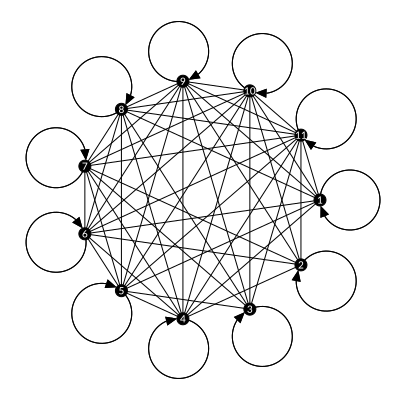

In [8]:
plot(QUBOTools.SystemLayoutPlot(Q))

Let's define a QUBO model and then solve it via simulated annealing.

In [9]:
using JuMP
using QUBO
using DWave

    CondaPkg Found dependencies: /home/pedroxavier/gits/DWave.jl/CondaPkg.toml

    CondaPkg Found dependencies: /home/pedroxavier/.julia/packages/PythonCall/1f5yE/CondaPkg.toml


    CondaPkg Found dependencies: /home/pedroxavier/.julia/packages/DWaveNeal/3cu1x/CondaPkg.toml


    CondaPkg Found dependencies: /home/pedroxavier/.julia/packages/PythonPlot/f591M/CondaPkg.toml


    CondaPkg Found dependencies: /home/pedroxavier/gits/DWave.jl/CondaPkg.toml


    CondaPkg Found dependencies: /home/pedroxavier/.julia/packages/PythonCall/1f5yE/CondaPkg.toml


    CondaPkg Dependencies already up to date


In [10]:
# Define empty model
qubo_model = Model()

# Define the variables
@variable(qubo_model, x[1:11], Bin)

# Define the objective function
@objective(qubo_model, Min, x' * Q * x + β)

# Print the model
print(qubo_model)

Min -46 x[1]² + 96 x[4]*x[1] + 96 x[5]*x[1] + 96 x[6]*x[1] + 96 x[8]*x[1] + 96 x[9]*x[1] + 96 x[10]*x[1] + 96 x[11]*x[1] - 44 x[2]² + 96 x[4]*x[2] + 96 x[6]*x[2] + 96 x[7]*x[2] + 96 x[9]*x[2] + 96 x[10]*x[2] + 96 x[11]*x[2] - 44 x[3]² + 96 x[5]*x[3] + 96 x[7]*x[3] + 96 x[8]*x[3] + 96 x[9]*x[3] + 96 x[10]*x[3] + 96 x[11]*x[3] - 92 x[4]² + 96 x[5]*x[4] + 192 x[6]*x[4] + 96 x[7]*x[4] + 96 x[8]*x[4] + 192 x[9]*x[4] + 192 x[10]*x[4] + 192 x[11]*x[4] - 92 x[5]² + 96 x[6]*x[5] + 96 x[7]*x[5] + 192 x[8]*x[5] + 192 x[9]*x[5] + 192 x[10]*x[5] + 192 x[11]*x[5] - 92 x[6]² + 96 x[7]*x[6] + 96 x[8]*x[6] + 192 x[9]*x[6] + 192 x[10]*x[6] + 192 x[11]*x[6] - 91 x[7]² + 96 x[8]*x[7] + 192 x[9]*x[7] + 192 x[10]*x[7] + 192 x[11]*x[7] - 92 x[8]² + 192 x[9]*x[8] + 192 x[10]*x[8] + 192 x[11]*x[8] - 139 x[9]² + 288 x[10]*x[9] + 288 x[11]*x[9] - 138 x[10]² + 288 x[11]*x[10] - 139 x[11]² + 144
Subject to
 

x[1] binary
 x[2] binary
 x[3] binary
 x[4] binary
 x[5] binary
 x[6] binary
 x[7] binary
 x[8] binary
 x[9] binary
 x[10] binary
 x[11] binary


In [11]:
# Use D-Wave's simulated annealer 'Neal'
set_optimizer(qubo_model, DWave.Neal.Optimizer)

set_optimizer_attribute(qubo_model, "num_reads", 1_000)

optimize!(qubo_model)

println("Minimum energy: $(objective_value(qubo_model))")

Minimum energy: 5.0


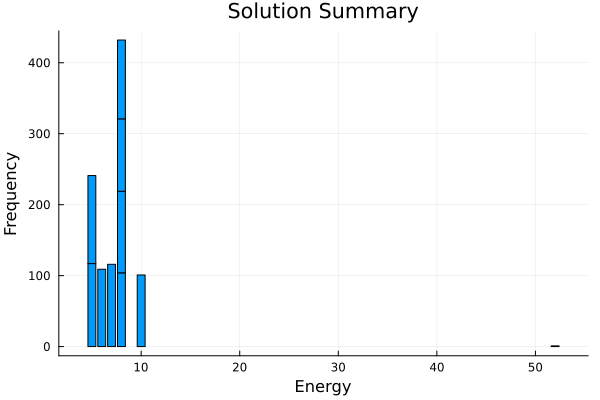

In [14]:
plot(QUBOTools.EnergyFrequencyPlot(qubo_model))

Notice that this is the same example we have been solving earlier (via Integer Programming in the Quiz 2, via Ising model and QUBO in Notebook 2).

## Now let's solve this using Quantum Annealing!

First, we start by defining the `DWAVE_API_TOKEN` environment variable.

In [ ]:
ENV["DWAVE_API_TOKEN"] = "<YOUR_KEY_HERE>";

In [16]:
# Use D-Wave's quantum annealer
set_optimizer(qubo_model, DWave.Optimizer)

set_optimizer_attribute(qubo_model, "num_reads", 1024)

optimize!(qubo_model)

println("Minimum energy: $(objective_value(qubo_model))")

Minimum energy: 5.0


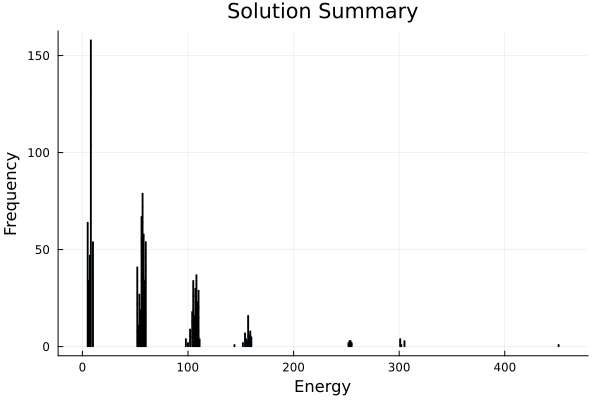

In [17]:
plot(QUBOTools.EnergyFrequencyPlot(qubo_model))

In [ ]:
using Graphs

In [ ]:
# Graph corresponding to D-Wave 2000Q
sampler = DWave.dwave_system.DWaveSampler(token = ENV["DWAVE_API_TOKEN"])

In [ ]:
function get_topology(sampler)
    if string(sampler.solver.id) == "DW_2000Q_6"
        return DWave.dwave_networkx.chimera_graph(
            16,
            node_list=sampler.nodelist,
            edge_list=sampler.edgelist,
        )
    elseif string(sampler.solver.id) == "Advantage_system1.1"
        return DWave.dwave_networkx.pegasus_graph(
            16,
            node_list=sampler.nodelist,
            edge_list=sampler.edgelist,
        )
    elseif string(sampler.solver.id) == "Advantage_system4.1"
        return DWave.dwave_networkx.pegasus_graph(
            16,
            node_list=sampler.nodelist,
            edge_list=sampler.edgelist,
        )
    else
        error("Unknown solver id '$(sampler.solver.id)'")

        return nothing
    end
end

function draw_topology(sampler)
    χ = get_topology(sampler)

    g = Graphs.grpah
end

draw_topology(sampler)

In [19]:
sol = QUBOTools.sampleset(unsafe_backend(qubo_model))

149-element QUBOTools.SampleSet{Float64, Int64}:
 [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1]
 [-1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1]
 [-1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1]
 [1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1]
 [-1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1]
 [-1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1]
 [-1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1]
 [-1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1]
 [1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1]
 [-1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1]
 ⋮
 [-1, -1, -1, 1, -1, -1, -1, 1, -1, -1, 1]
 [-1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1]
 [-1, -1, -1, 1, 1, -1, -1, -1, 1, -1, -1]
 [1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1]
 [-1, -1, -1, 1, -1, -1, 1, -1, 1, -1, -1]
 [-1, 1, 1, -1, -1, -1, -1, 1, -1, -1, 1]
 [-1, 1, 1, -1, 1, -1, -1, -1, -1, -1, 1]
 [-1, 1, 1, 1, -1, -1, -1, -1, 1, -1, -1]
 [1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1]

In [20]:
data = QUBOTools.metadata(sol)
info = get(data, "dwave_info", nothing)

Python: {'timing': {'qpu_sampling_time': 88043.52, 'qpu_anneal_time_per_sample': 20.0, 'qpu_readout_time_per_sample': 45.44, 'qpu_access_time': 103802.29, 'qpu_access_overhead_time': 4434.71, 'qpu_programming_time': 15758.77, 'qpu_delay_time_per_sample': 20.54, 'post_processing_overhead_time': 2044.0, 'total_post_processing_time': 2044.0}, 'problem_id': 'cb0dd99d-cc2d-487d-9161-75ab2c607cca'}

Now we can play with the other parameters such as Annealing time, chain strenght, and annealing schedule to improve the performance of D-Wave's Quantum Annealing.

# References

- [Julia Colab Notebook Template](https://colab.research.google.com/github/ageron/julia_notebooks/blob/master/Julia_Colab_Notebook_Template.ipynb)
- [QuIPML22](https://github.com/bernalde/QuIPML22/)

<a name="installation" id="installation"></a>

# Installation

## Colab Instructions

If not in a Colab notebook, continue to the next section.

1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other required packages. This can take a couple of minutes.
3. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2 and 3.

In [ ]:
%%shell

bash <(curl -s "https://raw.githubusercontent.com/pedromxavier/QUBO-notebooks/main/scripts/install-colab-julia.sh")

## Validate Installation

In [ ]:
versioninfo()

## Local Installation Instructions

If you don't have a Julia installation yet, consider using [juliaup](https://github.com/JuliaLang/juliaup).
Otherwise, run the next cell to install the necessary packages.

### Install Julia Packages

In [ ]:
import Pkg

Pkg.activate(@__DIR__)
Pkg.instantiate(; io = devnull) # Suppress Output

<div align="center">
    <a href="#top">🔝 Go back to the top 🔝</a>
</div>